## Introduction
To enhance my understanding of the Fas.ai API and Pytorsch framework, I've selected a dataset that I have previously cleaned and prepared specifically for machine learning projects.

In [1]:
#!pip install fastai
import pandas as pd
import numpy as np

## Data Loading

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/Tomas4python/green_taxi_20/master/cleaned_project_data_20.csv')
data

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,total_amount,trip_duration,night,peak_hour,congestion,amount_without_tip
0,2020-01-01 00:45:58,2020-01-01 00:56:39,66,65,1.28,20.0,24.36,641.0,1,0,0,20.30
1,2020-01-01 00:41:38,2020-01-01 00:52:49,181,228,2.47,10.5,15.34,671.0,1,0,0,11.80
2,2020-01-01 00:52:46,2020-01-01 01:14:21,129,263,6.30,21.0,25.05,1295.0,1,0,1,25.05
3,2020-01-01 00:19:57,2020-01-01 00:30:56,210,150,2.30,10.0,11.30,659.0,1,0,0,11.30
4,2020-01-01 00:52:33,2020-01-01 01:09:54,35,39,3.00,13.5,14.80,1041.0,1,0,0,14.80
...,...,...,...,...,...,...,...,...,...,...,...,...
1128350,2020-12-31 23:08:35,2020-12-31 23:13:00,41,74,0.79,5.0,6.30,265.0,1,0,0,6.30
1128351,2020-12-31 23:11:04,2020-12-31 23:20:08,41,116,2.31,12.0,12.30,544.0,1,0,0,12.30
1128352,2020-12-31 23:24:33,2020-12-31 23:40:24,116,119,5.73,20.0,20.30,951.0,1,0,0,20.30
1128353,2020-12-31 23:13:59,2020-12-31 23:16:20,42,42,0.31,3.5,4.80,141.0,1,0,0,4.80


## Data Preprocessing

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

train_idx, temp_idx = train_test_split(np.arange(len(data)), test_size=0.3, random_state=22)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.33, random_state=22)

splits = (list(train_idx), list(val_idx))


In [4]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    device = torch.device('cuda')
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device('cpu')

CUDA is available. Using GPU.


In [5]:
from fastai.tabular.all import *

defaults.device = device

#splits = RandomSplitter(valid_pct=0.2)(range_of(data))

dls = TabularDataLoaders.from_df(data, 
                                 path='.', 
                                 y_names="amount_without_tip", 
                                 cont_names=['PULocationID', 'DOLocationID', 'trip_distance', 'trip_duration', 'night', 'peak_hour', 'congestion'], 
                                 procs=[Categorify, FillMissing, Normalize],
                                 splits=splits,
                                 bs=128)

## Create Learner

SuggestedLRs(valley=0.02754228748381138)

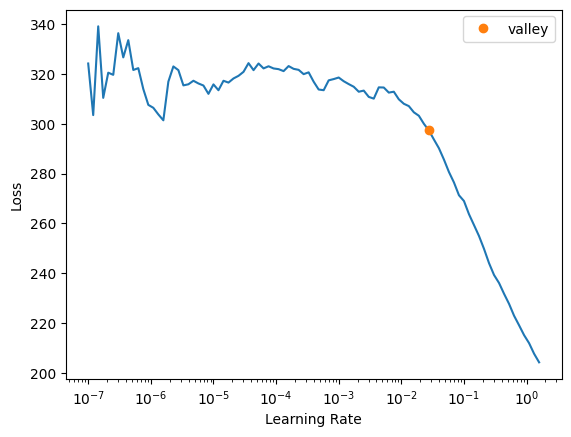

In [6]:
learn = tabular_learner(dls, layers=[128, 64, 64, 64, 32], n_out=1, y_range=None, metrics=rmse)
learn.lr_find()

## Train Model

In [7]:
from fastai.callback.tracker import EarlyStoppingCallback

learn.fit_one_cycle(200, 0.001, cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=25)])

epoch,train_loss,valid_loss,_rmse,time
0,133.476303,127.755745,11.302907,01:43
1,18.991037,16.559080,4.069286,01:51
2,6.979771,6.517850,2.553008,01:55
3,7.837533,5.983311,2.446080,01:50
4,9.213694,6.280612,2.506114,01:56
5,8.998983,6.216829,2.493357,01:54
6,8.419442,6.059274,2.461559,01:50
7,7.908163,6.408748,2.531551,01:50
8,8.080261,6.737675,2.595702,01:51
9,6.943322,6.217661,2.493524,01:52


No improvement since epoch 12: early stopping


## Evaluate Model

In [8]:
learn.show_results()

,PULocationID,DOLocationID,trip_distance,trip_duration,night,peak_hour,congestion,amount_without_tip,amount_without_tip_pred
0,1.013435,0.142387,0.560322,-0.148797,1.822765,-0.528704,2.084753,20.049999,20.412670
1,-0.124588,-0.105736,-0.131881,0.132186,-0.548617,-0.528704,-0.479673,12.800000,12.694407
2,0.444424,-1.555293,-0.382312,-0.239388,-0.548617,1.891417,-0.479673,10.300000,10.680457
3,-0.079666,-0.615040,0.262056,0.600491,-0.548617,-0.528704,-0.479673,17.299999,16.760029
4,-0.394119,0.142387,0.211407,-0.108876,-0.548617,-0.528704,2.084753,16.549999,16.769674
5,0.773851,0.299096,-0.638371,-0.781393,-0.548617,1.891417,-0.479673,6.800000,7.284123
6,1.013435,0.690868,0.188896,1.027340,-0.548617,-0.528704,-0.479673,18.299999,17.977421
7,1.837004,-1.594470,-0.514562,-0.353009,-0.548617,-0.528704,-0.479673,8.300000,8.334351
8,-0.079666,-1.320230,0.205779,-0.695410,1.822765,-0.528704,-0.479673,10.000000,16.498800


## Evaluate On Test Data

In [9]:
test_df = data.iloc[test_idx]
test_dl = dls.test_dl(test_df, bs=128)
test_preds, test_targets = learn.get_preds(dl=test_dl)

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

test_preds_np = test_preds.numpy().flatten()
test_targets_np = test_targets.numpy().flatten()

mae = mean_absolute_error(test_targets_np, test_preds_np)
mse = mean_squared_error(test_targets_np, test_preds_np)
rmse = np.sqrt(mse)
mean_test_targets = np.mean(test_targets_np)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean of Test Data Targets: {mean_test_targets}')

Mean Absolute Error (MAE): 0.7934556007385254
Mean Squared Error (MSE): 6.516618251800537
Root Mean Squared Error (RMSE): 2.552766799926758
Mean of Test Data Targets: 14.267934799194336


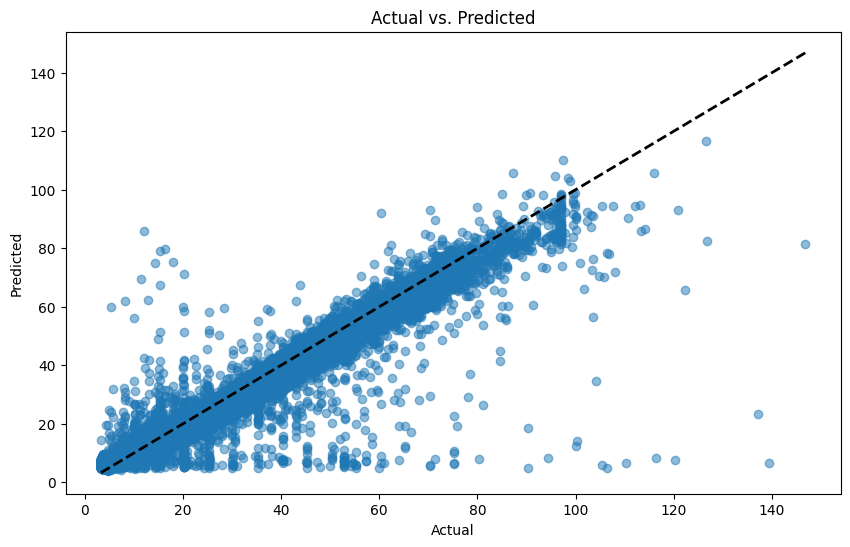

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(test_targets_np, test_preds_np, alpha=0.5)
plt.plot([test_targets_np.min(), test_targets_np.max()], [test_targets_np.min(), test_targets_np.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()